In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import requests

In [2]:
fileURL = './crime_data_latest.csv'
crime_data = pd.read_csv(fileURL, header=0)

In [3]:
# Added a new column named range for easier further use.

crime_data['RANGE'] = '0'
crime_data.loc[((crime_data.YEAR == 2015) & (crime_data.MONTH >= 1)) | ((crime_data.YEAR == 2016) & (crime_data.MONTH <= 6)),'RANGE'] = '2015-2016'
crime_data.loc[((crime_data.YEAR == 2016) & (crime_data.MONTH >= 1)) | ((crime_data.YEAR == 2017) & (crime_data.MONTH <= 6)),'RANGE'] = '2016-2017'
crime_data.loc[((crime_data.YEAR == 2017) & (crime_data.MONTH >= 1)) | ((crime_data.YEAR == 2018) & (crime_data.MONTH <= 6)),'RANGE'] = '2017-2018'
crime_data.loc[((crime_data.YEAR == 2018) & (crime_data.MONTH >= 1)) | ((crime_data.YEAR == 2019) & (crime_data.MONTH <= 6)),'RANGE'] = '2018-2019'

In [4]:
crime_data = crime_data.fillna(0)
crime_data.head(15)

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,RANGE
0,I192050013,2403,Disorderly Conduct,DISTURBING THE PEACE,C11,341,0,6/30/2019 23:55,2019,6,Sunday,23,Part Two,BOWDOIN ST,42.305740,-71.067624,"(42.30573977, -71.06762362)",2018-2019
1,I192050013,2405,Disorderly Conduct,DISORDERLY CONDUCT,C11,341,0,6/30/2019 23:55,2019,6,Sunday,23,Part Two,BOWDOIN ST,42.305740,-71.067624,"(42.30573977, -71.06762362)",2018-2019
2,I192050019,3503,Missing Person Located,MISSING PERSON - NOT REPORTED - LOCATED,B2,319,0,6/30/2019 23:30,2019,6,Sunday,23,Part Three,CHENEY ST,42.309700,-71.085824,"(42.30970016, -71.08582414)",2018-2019
3,I192050009,3115,Investigate Person,INVESTIGATE PERSON,B3,418,0,6/30/2019 23:17,2019,6,Sunday,23,Part Three,FULLER ST,42.280093,-71.080054,"(42.28009279, -71.08005410)",2018-2019
4,I192050004,3501,Missing Person Reported,MISSING PERSON,C6,175,0,6/30/2019 23:17,2019,6,Sunday,23,Part Three,SOUTHAMPTON ST,42.332108,-71.070144,"(42.33210843, -71.07014395)",2018-2019
5,I192050006,3001,Medical Assistance,DEATH INVESTIGATION,A1,111,0,6/30/2019 23:10,2019,6,Sunday,23,Part Three,WASHINGTON ST,42.353581,-71.062367,"(42.35358129, -71.06236665)",2018-2019
6,I192050006,3007,Medical Assistance,SUDDEN DEATH,A1,111,0,6/30/2019 23:10,2019,6,Sunday,23,Part Three,WASHINGTON ST,42.353581,-71.062367,"(42.35358129, -71.06236665)",2018-2019
7,I192052344,619,Larceny,LARCENY ALL OTHERS,D4,624,0,6/30/2019 22:45,2019,6,Sunday,22,Part One,LANSDOWNE ST,42.347174,-71.096444,"(42.34717363, -71.09644390)",2018-2019
8,I192050141,1402,Vandalism,VANDALISM,C11,392,0,6/30/2019 22:30,2019,6,Sunday,22,Part Two,BATESWELL RD,0.000000,0.000000,"(0.00000000, 0.00000000)",2018-2019
9,I192050000,3410,Towed,TOWED MOTOR VEHICLE,D4,594,0,6/30/2019 22:27,2019,6,Sunday,22,Part Three,MASSACHUSETTS AVE,42.341870,-71.083722,"(42.34186952, -71.08372190)",2018-2019


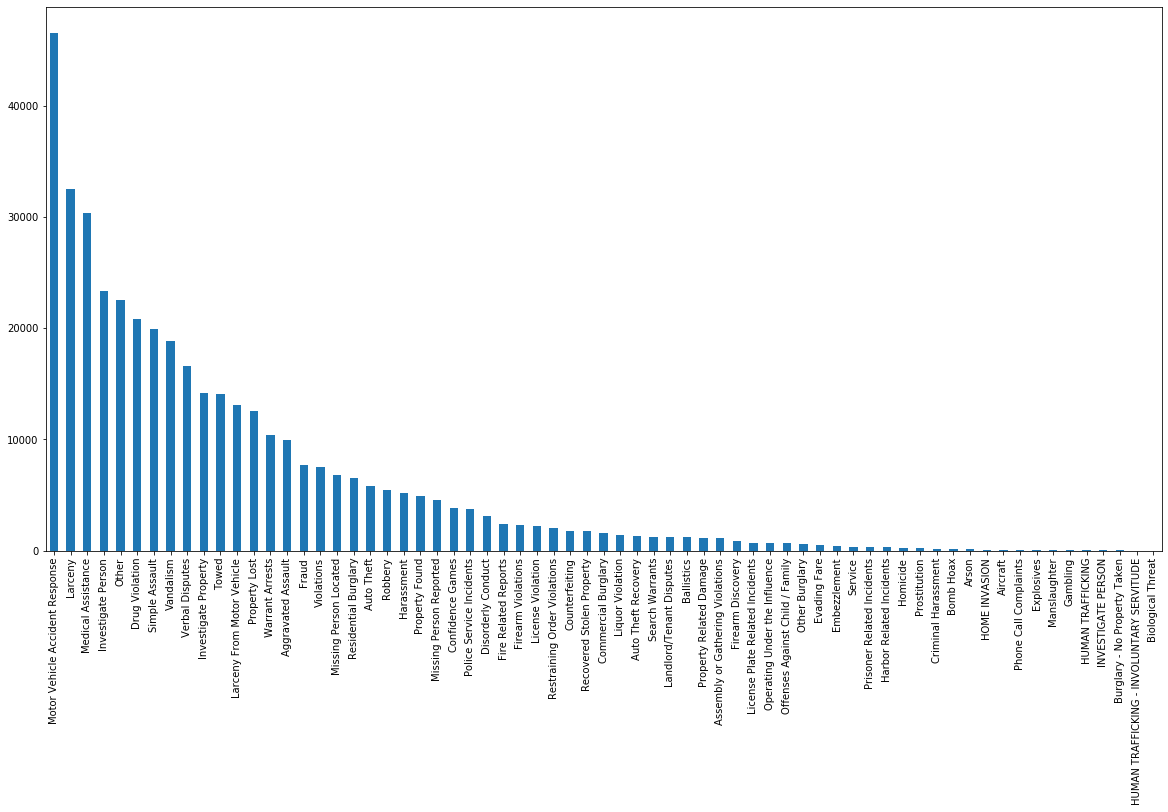

In [5]:
pd.value_counts(crime_data.OFFENSE_CODE_GROUP).plot.bar(figsize=(20,10))

In [6]:
pd.value_counts(crime_data.STREET).head(10).drop(0)

WASHINGTON ST        18133
BLUE HILL AVE         9866
BOYLSTON ST           9002
DORCHESTER AVE        6336
TREMONT ST            6113
HARRISON AVE          5915
MASSACHUSETTS AVE     5915
CENTRE ST             5543
COMMONWEALTH AVE      5214
Name: STREET, dtype: int64

In [7]:
pd.value_counts(crime_data.SHOOTING)

0    398191
Y      1614
Name: SHOOTING, dtype: int64

In [8]:
# Year and crime type stats

crime_data.groupby(['OFFENSE_CODE_GROUP','RANGE']).size()

OFFENSE_CODE_GROUP                RANGE    
Aggravated Assault                2015-2016    1415
                                  2016-2017    2399
                                  2017-2018    2451
                                  2018-2019    3651
Aircraft                          2015-2016       4
                                  2016-2017       4
                                  2017-2018      22
                                  2018-2019      25
Arson                             2015-2016      11
                                  2016-2017      34
                                  2017-2018      32
                                  2018-2019      30
Assembly or Gathering Violations  2015-2016     240
                                  2016-2017     334
                                  2017-2018     243
                                  2018-2019     287
Auto Theft                        2015-2016     988
                                  2016-2017    1543
                    

In [9]:
# Filtering part one crimes and then getting its stats

part_one_crime = crime_data[crime_data.UCR_PART == 'Part One']
part_one_crime.groupby(['OFFENSE_CODE_GROUP','RANGE']).size()

OFFENSE_CODE_GROUP          RANGE    
Aggravated Assault          2015-2016     1415
                            2016-2017     2399
                            2017-2018     2451
                            2018-2019     3651
Auto Theft                  2015-2016      988
                            2016-2017     1543
                            2017-2018     1398
                            2018-2019     1880
Commercial Burglary         2015-2016      261
                            2016-2017      431
                            2017-2018      433
                            2018-2019      470
Homicide                    2015-2016       40
                            2016-2017       56
                            2017-2018       67
                            2018-2019      101
Larceny                     2015-2016     5030
                            2016-2017     7926
                            2017-2018     7825
                            2018-2019    11703
Larceny From Motor Veh

In [10]:
# Crime data of Part One crimes based on streets

part_one_crime.groupby(['OFFENSE_CODE_GROUP','RANGE','STREET']).size()

OFFENSE_CODE_GROUP  RANGE      STREET                  
Aggravated Assault  2015-2016  0                           44
                                ALBANY ST                   2
                                COMMONWEALTH AVE            1
                               132 BROOK AVE                1
                               ACADEMY TER                  3
                               ACKLEY PL                    1
                               ADAMS ST                     7
                               ALBANY ST                    2
                               ALBION ST                    1
                               ALDRICH ST                   1
                               ALLSTATE RD                  5
                               ALLSTON ST                   2
                               ALMONT ST                    3
                               ALPHA RD                     3
                               ALPINE ST                    2
              

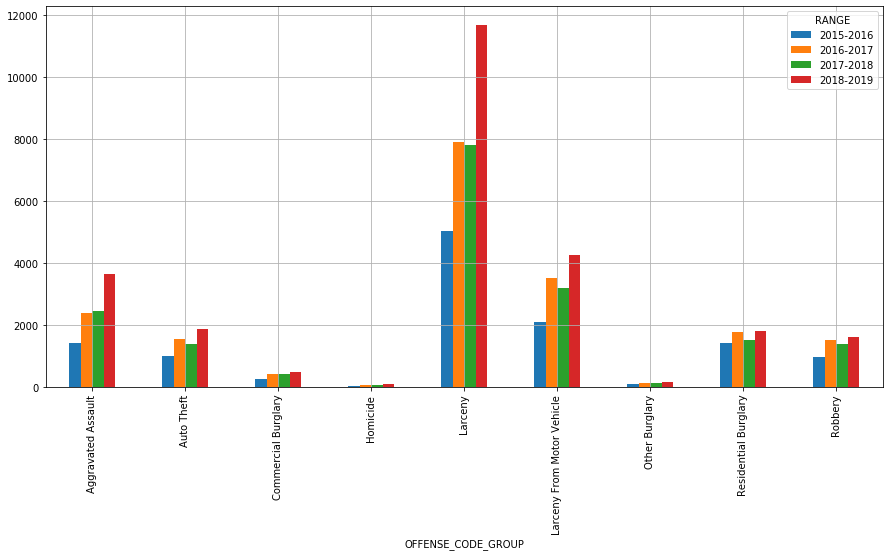

In [11]:
fig, ax = plt.subplots(figsize=(15,7))
part_one_crime.groupby(['OFFENSE_CODE_GROUP','RANGE']).count()['INCIDENT_NUMBER'].unstack().plot.bar(ax=ax, grid='True')

In [12]:
part_one_crime.groupby(['RANGE','STREET']).count()['INCIDENT_NUMBER'].unstack().fillna(0).T

RANGE,2015-2016,2016-2017,2017-2018,2018-2019
STREET,,,,
0,216.0,708.0,301.0,267.0
ALBANY ST,7.0,1.0,0.0,0.0
BLUE HILL AVE,0.0,0.0,1.0,1.0
COMMONWEALTH AVE,1.0,0.0,0.0,0.0
MASSACHUSETTS AVE,2.0,0.0,0.0,0.0
132 BROOK AVE,1.0,0.0,0.0,0.0
14 HALF MOON ST,1.0,0.0,0.0,0.0
1ST & O,1.0,0.0,0.0,0.0
20 PARKER HILL AVE,0.0,0.0,0.0,1.0


In [13]:
def sorted(s, num):
    tmp = s.sort_values(ascending=False)[:num]  # earlier s.order(..)
    tmp.index = range(num)
    return tmp
part_one_crime.groupby(['RANGE','STREET']).count()['INCIDENT_NUMBER'].unstack().fillna(0).T.apply(lambda x: sorted(x, 10))

RANGE,2015-2016,2016-2017,2017-2018,2018-2019
0,647.0,984.0,969.0,1369.0
1,529.0,828.0,850.0,1157.0
2,235.0,708.0,422.0,634.0
3,232.0,421.0,383.0,534.0
4,216.0,365.0,348.0,475.0
5,216.0,342.0,337.0,466.0
6,198.0,327.0,320.0,454.0
7,190.0,318.0,301.0,450.0
8,176.0,296.0,299.0,377.0
9,173.0,277.0,276.0,363.0


In [14]:
# datetime.datetime.strptime("6/30/2019 23:55", '%m/%d/%Y HH:MM').strftime('%m/%d/%y')
def date_time_conversion(dt):
    datetime_object = datetime.strptime(dt, '%m/%d/%Y %H:%M').strftime('%Y-%m-%d')
    return datetime_object
crime_data['OCCURRED_ON_DATE'] = crime_data.OCCURRED_ON_DATE.apply(lambda x: date_time_conversion(x))

In [15]:
date_count_data = pd.DataFrame(crime_data.groupby(['OCCURRED_ON_DATE']).count()['INCIDENT_NUMBER'])

E:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


Test MSE: 966.139


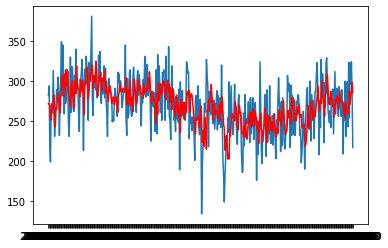

<Figure size 1080x504 with 0 Axes>

In [23]:
train, test = date_count_data[:"2018-04-13"], date_count_data["2018-04-13":]
predictions = list()

for index, row in test.iterrows():
    model = ARIMA(train, order=(6,1,0),freq='D')
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    train.loc[index] = row.INCIDENT_NUMBER
#     print('predicted=%f, expected=%f' % (yhat, row.INCIDENT_NUMBER))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.figure(figsize=(15,7))
pyplot.show()

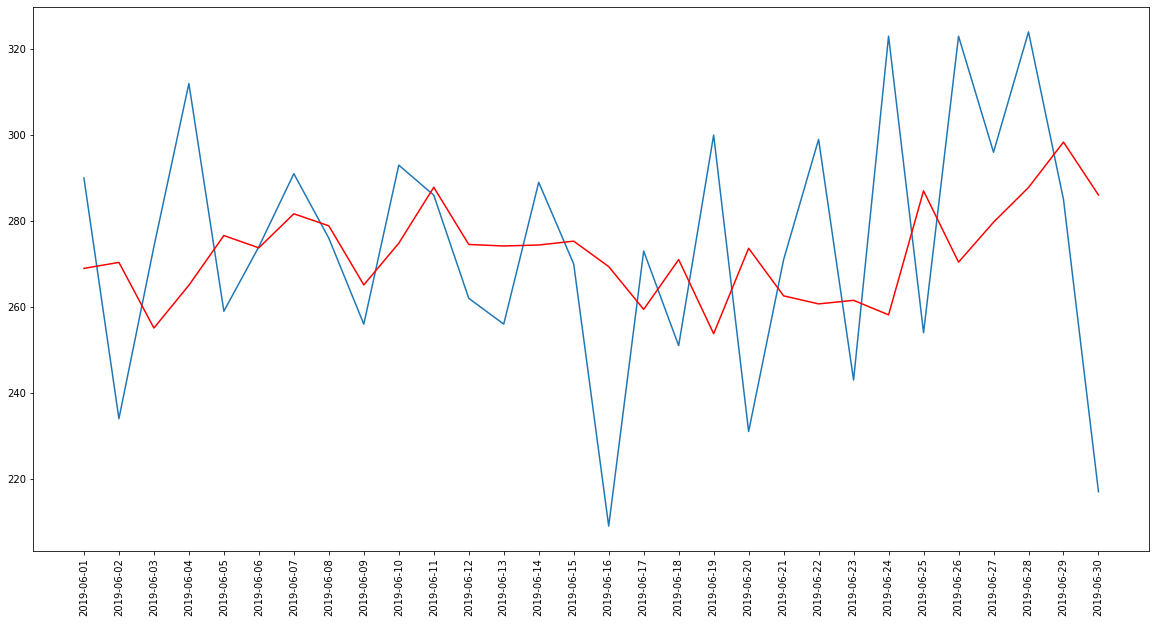

In [17]:
pyplot.figure(figsize=(20,10))
pyplot.plot(test.tail(30))
pyplot.plot(predictions[-30:], color='red')
pyplot.xticks(rotation='vertical')
pyplot.show()

In [27]:
district_date_data = pd.DataFrame(crime_data.groupby(['DISTRICT','OCCURRED_ON_DATE']).count()['INCIDENT_NUMBER'])

In [45]:
location_to_zip = dict()

In [55]:
def find_zip_codes(location):
    location = location.replace('(','')
    location = location.replace(')','')
    location = location.replace(' ','')
    # api-endpoint 
    URL = "http://open.mapquestapi.com/geocoding/v1/reverse"

    # defining a params dict for the parameters to be sent to the API 
    PARAMS = {'key':"0UivSSWlMrR71m5haZ8pJJxWAW4vE3KL",'location':location} 
    
    if location in location_to_zip:
        return location_to_zip[location]
    
    # sending get request and saving the response as response object 
    r = requests.get(url = URL, params = PARAMS) 

    # extracting data in json format 
    data = r.json()
    location_to_zip[location] = data['results'][0]['locations'][0]['postalCode']
    return data['results'][0]['locations'][0]['postalCode']

crime_data['ZIP'] = crime_data.Location.apply(lambda x: find_zip_codes(x))

In [56]:
len(location_to_zip)

18767